In [2]:
import numpy as np
from numpy import random as rnd
from matplotlib import pyplot as plt
import warnings,os,time,datetime,sys

import torch
import pandas as pd

import gym

warnings.filterwarnings('ignore')

In [19]:
class Net(torch.nn.Module):
    def __init__(self,input_shape,output_shape):
        super(Net,self).__init__()
        self.l_in = torch.nn.Linear(input_shape,8)
        self.l_out = torch.nn.Linear(8,output_shape)
        self.optimizer = torch.optim.Adam(self.parameters(),lr=0.05)
    def forward(self,x):
        x = torch.nn.functional.relu(self.l_in(x))
        x = torch.nn.functional.softmax(self.l_out(x))
        return x
    def discount_rewards(self,rewards,gamma=0.99):
        r = np.array([gamma**k*rewards[k] for k in range(len(rewards))])
        r = r[::-1].cumsum()[::-1]
        return r-r.mean()
    def action_probs_as_numpy(self,s):
        action_p = self(torch.FloatTensor(s)).detach().numpy()
        return action_p
    def train(self,states,rewards,actions):
        self.optimizer.zero_grad()
        state_t = torch.FloatTensor(states)
        reward_t = torch.FloatTensor(rewards)
        action_t = torch.LongTensor(actions)
        logprob = torch.log(net(state_t))
        selected_logprobs = reward_t*torch.gather(logprob,1,action_t.reshape(action_t.shape[0],1)).squeeze()
        loss = -selected_logprobs.mean()
        loss.backward()
        self.optimizer.step()
        return

In [20]:
NUM_EPISODES = 100
BATCH_SIZE = 1

In [21]:
net = Net(2,3)

In [22]:
env = gym.make('MountainCar-v0')

total_rewards = []
batch_rewards = []
batch_actions = []
batch_states = []

viz_step = int(5**np.floor(np.log10(NUM_EPISODES)))
batch_counter = 1

episodes = 0
while episodes<NUM_EPISODES:

    s0 = env.reset()

    states = []
    rewards = []
    actions = []

    done = False
    while not done:

        action_probs = net.action_probs_as_numpy(s0)
        action_c = rnd.choice(np.arange(env.action_space.n),p=action_probs)

        s1,r,done,_ = env.step(action_c)

        states.append(s0)
        rewards.append(r)
        actions.append(action_c)

        s0 = s1

        if done:

            total_rewards.append(sum(rewards))

            batch_states.extend(states)
            batch_rewards.extend(net.discount_rewards(rewards))
            batch_actions.extend(actions)

            batch_counter += 1

            if batch_counter==BATCH_SIZE:
                net.train(batch_states,batch_rewards,batch_actions)
                batch_states = []
                batch_rewards = []
                batch_actions = []
                batch_counter = 1
            episodes += 1
    if episodes%viz_step==0: print('{}/{} -> Avg rewards: {}'.format(episodes,NUM_EPISODES,np.mean(total_rewards[-viz_step:])))
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
25/100 -> Avg rewards: -200.0
50/100 -> Avg rewards: -200.0
75/100 -> Avg rewards: -200.0
100/100 -> Avg rewards: -200.0


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
25/300 -> Avg rewards: 21.52
50/300 -> Avg rewards: 35.24
75/300 -> Avg rewards: 31.44
100/300 -> Avg rewards: 34.12
125/300 -> Avg rewards: 47.52
150/300 -> Avg rewards: 51.88
175/300 -> Avg rewards: 64.36
200/300 -> Avg rewards: 103.96
225/300 -> Avg rewards: 153.0
250/300 -> Avg rewards: 197.96
275/300 -> Avg rewards: 188.12
300/300 -> Avg rewards: 183.88


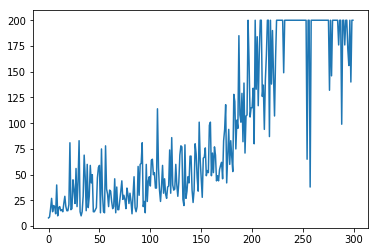

In [287]:
net = Net(4,2)
training_rewards = train_net_cartpole(net,BATCH_SIZE=5,NUM_EPISODES=300)

plt.plot(training_rewards)
plt.show()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


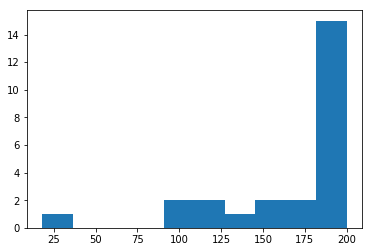

In [288]:
test_rewards = test_net_cartpole(net)

plt.hist(test_rewards)
plt.show()